# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>AEC Enrolment data</a></span><ul class="toc-item"><li><span><a href="#2022-Enrolment" data-toc-modified-id="2022-Enrolment-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>2022 Enrolment</a></span></li></ul></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preferences-by-party" data-toc-modified-id="First-preferences-by-party-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>First preferences by party</a></span></li><li><span><a href="#First-Preferences-by-Division-by-Vote-type" data-toc-modified-id="First-Preferences-by-Division-by-Vote-type-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>First Preferences by Division by Vote-type</a></span></li><li><span><a href="#First-preference-by-state" data-toc-modified-id="First-preference-by-state-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>First preference by state</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li><li><span><a href="#Two-Party-Preferred-by-Division" data-toc-modified-id="Two-Party-Preferred-by-Division-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Two Party Preferred by Division</a></span></li><li><span><a href="#Two-candidate-preferred-by-Division" data-toc-modified-id="Two-candidate-preferred-by-Division-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Two candidate preferred by Division</a></span></li></ul></li></ul></li><li><span><a href="#Data-consistency-checks" data-toc-modified-id="Data-consistency-checks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data consistency checks</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#First-preferences-by-party" data-toc-modified-id="First-preferences-by-party-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>First preferences by party</a></span></li><li><span><a href="#State-2pp-swings" data-toc-modified-id="State-2pp-swings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>State 2pp swings</a></span></li><li><span><a href="#State-primary-first-preference-swings" data-toc-modified-id="State-primary-first-preference-swings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>State primary first preference swings</a></span></li><li><span><a href="#Divisional-2pp-swings" data-toc-modified-id="Divisional-2pp-swings-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Divisional 2pp swings</a></span></li><li><span><a href="#Green-TCP-swings" data-toc-modified-id="Green-TCP-swings-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Green TCP swings</a></span></li><li><span><a href="#Traditional-TCP-swings" data-toc-modified-id="Traditional-TCP-swings-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Traditional TCP swings</a></span></li></ul></li><li><span><a href="#Seat-allocations" data-toc-modified-id="Seat-allocations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Seat allocations</a></span><ul class="toc-item"><li><span><a href="#Tally-Class" data-toc-modified-id="Tally-Class-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tally Class</a></span></li><li><span><a href="#Get-status-of-individual-seats" data-toc-modified-id="Get-status-of-individual-seats-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Get status of individual seats</a></span></li><li><span><a href="#Thresholds-for-counting-purposes" data-toc-modified-id="Thresholds-for-counting-purposes-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Thresholds for counting purposes</a></span></li><li><span><a href="#Initialise-tally---apply-any-manual-blocks" data-toc-modified-id="Initialise-tally---apply-any-manual-blocks-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Initialise tally - apply any manual blocks</a></span></li><li><span><a href="#Do-the-declared-seats" data-toc-modified-id="Do-the-declared-seats-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Do the declared seats</a></span></li><li><span><a href="#Ugly-manual-adjustments" data-toc-modified-id="Ugly-manual-adjustments-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Ugly manual adjustments</a></span></li><li><span><a href="#First-Preferences" data-toc-modified-id="First-Preferences-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>First Preferences</a></span></li><li><span><a href="#TCP-counts" data-toc-modified-id="TCP-counts-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>TCP counts</a></span></li><li><span><a href="#State-of-play" data-toc-modified-id="State-of-play-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>State of play</a></span></li><li><span><a href="#State-of-the-House" data-toc-modified-id="State-of-the-House-5.10"><span class="toc-item-num">5.10&nbsp;&nbsp;</span>State of the House</a></span></li><li><span><a href="#House-outcome-and-closer-seats" data-toc-modified-id="House-outcome-and-closer-seats-5.11"><span class="toc-item-num">5.11&nbsp;&nbsp;</span>House outcome and closer seats</a></span></li><li><span><a href="#Hypothetically-allocate-remainders-by-hand" data-toc-modified-id="Hypothetically-allocate-remainders-by-hand-5.12"><span class="toc-item-num">5.12&nbsp;&nbsp;</span>Hypothetically allocate remainders by hand</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# system imports
from pathlib import Path
import itertools
import numbers
import math
from datetime import datetime
from typing import Any, Union, Iterable, Optional, List, Dict
from copy import deepcopy


# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Jun 12 2022 07:03:03

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
matplotlib: 3.5.2

Watermark: 2.3.1



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = f'Election data from AEC {datetime.now().now().strftime("%d/%m/%Y %H:%M")}. '
LFOOTER

'Election data from AEC 12/06/2022 07:03. '

## Get data

### AEC Enrolment data

#### 2022 Enrolment

In [5]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preferences by party

In [6]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [7]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [8]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [9]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     35.693746
Labor         32.577192
Green         12.252366
One Nation     4.964528
UAP            4.125288
Other         10.386880
dtype: float64

In [10]:
primary_tally.sum()

100.00000000000001

#### First Preferences by Division by Vote-type

In [11]:
houseFirstPrefsByCandidate = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
print(houseFirstPrefsByCandidate.columns)
vote_types = ['OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
              'PrePollVotes', 'PostalVotes',]

# __Note__: this includes informal votes
(houseFirstPrefsByCandidate[vote_types].sum(), 
 f'Total:           {houseFirstPrefsByCandidate[vote_types].sum().sum():,}')

Index(['StateAb', 'DivisionID', 'DivisionNm', 'CandidateID', 'Surname',
       'GivenNm', 'BallotPosition', 'Elected', 'HistoricElected', 'PartyAb',
       'PartyNm', 'OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
       'PrePollVotes', 'PostalVotes', 'TotalVotes', 'Swing'],
      dtype='object')


(OrdinaryVotes       12149578
 AbsentVotes           494528
 ProvisionalVotes       49397
 PrePollVotes          554120
 PostalVotes          2208773
 dtype: int64,
 'Total:           15,456,396')

In [12]:
# Divisional first preference counts (including informal votes)
# Least counted divisions and most counted divisions ...

fp_count_pct = (
    houseFirstPrefsByCandidate.groupby('DivisionNm').sum()['TotalVotes']
    / enrolment_div * 100 )
fp_count_pct.sort_values().head(), fp_count_pct.sort_values().tail()

(DivisionNm
 Lingiari      66.791357
 Solomon       79.479190
 Durack        80.861688
 Leichhardt    83.932561
 Kennedy       84.529986
 dtype: float64,
 DivisionNm
 Franklin    93.307689
 Kooyong     93.373963
 Berowra     93.514308
 Mayo        93.597008
 Hughes      94.348199
 dtype: float64)

In [13]:
fp_formal_by_div_by_party = pd.pivot_table(houseFirstPrefsByCandidate, index='DivisionNm', 
                           columns='PartyAb', 
                           values='TotalVotes', aggfunc=pd.Series.sum)

# __Note__: the pivot table drops informal votes because they have no PartyAb
fp_formal_by_div_by_party.sum().sum()

14657789.0

In [14]:
# quick sanity check
assert not fp_formal_by_div_by_party.columns.has_duplicates

In [15]:
fp_fomal_vote_pct_party = (
    (fp_formal_by_div_by_party
    .div(fp_formal_by_div_by_party.sum(axis=1), axis=0) * 100)
    .round(3)
)
fp_fomal_vote_pct_party.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,39.981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.772,NaN,NaN,NaN,20.096,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,32.544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.075,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,44.731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708,NaN,NaN,NaN,14.592,NaN,NaN,NaN,2.119,NaN,NaN
Banks,NaN,35.264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.760,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,20.840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718,NaN,NaN,NaN,7.422,NaN,NaN,NaN,4.827,NaN,NaN
Barton,NaN,50.431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.478,NaN,NaN,NaN,NaN,NaN,NaN
Bass,1.412,28.609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.098,NaN,NaN,NaN,5.030,6.69,NaN
Bean,NaN,41.699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.807,NaN,NaN,NaN,8.159,NaN,NaN
Bendigo,NaN,42.975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.059,NaN,NaN,NaN,4.333,NaN,NaN


#### First preference by state 

In [16]:
houseFirstPrefsByStateByParty2022 = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByStateByPartyDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2022 = houseFirstPrefsByStateByParty2022.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2019 = (
    pd.read_csv('https://results.aec.gov.au/24310/Website/'
                'Downloads/HouseFirstPrefsByStateByPartyDownload-24310.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2019 = houseFirstPrefsByStateByParty2019.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2022

,StateAb,PartyNm,OrderOfAppearance,Contested,Nominations,Elected,OrdinaryVotes,OrdinaryPercentage,AbsentVotes,AbsentPercentage,ProvisionalVotes,ProvisionalPercentage,DeclarationPrePollVotes,DeclarationPrePollPercentage,PostalVotes,PostalPercentage,TotalVotes,TotalPercentage,TotalSwing
PartyAb,,,,,,,,,,,,,,,,,,,
LP,NSW,Liberal,1,38,38,5,1069258,27.78,29174,23.49,3048,23.78,38834,26.45,174702,33.95,1315016,28.29,-4.50
NP,NSW,The Nationals,2,9,9,1,335148,8.71,5144,4.14,483,3.77,9530,6.49,32495,6.31,382800,8.24,-1.52
ALP,NSW,Australian Labor Party,3,47,47,15,1290891,33.54,39879,32.11,4722,36.84,46526,31.68,169486,32.93,1551504,33.38,-1.18
UAPP,NSW,United Australia Party,4,47,47,0,153405,3.99,7880,6.35,719,5.61,6689,4.56,14367,2.79,183060,3.94,0.56
IND,NSW,Independent,5,27,37,3,298878,7.76,7224,5.82,817,6.37,8823,6.01,35811,6.96,351553,7.56,2.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDP,NT,Liberal Democratic Party,4,2,2,0,6431,7.32,178,9.64,17,4.74,652,12.53,509,8.98,7787,7.71,7.71
ON,NT,Pauline Hanson's One Nation,5,2,2,0,4521,5.15,122,6.61,13,3.62,415,7.97,347,6.12,5418,5.37,5.37
UAPP,NT,United Australia Party,6,2,2,0,3912,4.45,119,6.44,25,6.96,287,5.51,167,2.95,4510,4.47,1.62


#### Two party preferred votes by state

In [17]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1779425,48.47,1891849,51.53,3671274,-3.31,5472469,67.086246
VIC,VIC,Victoria,1335497,45.01,1631436,54.99,2966933,-1.85,4344208,68.296292
QLD,QLD,Queensland,1405048,55.10,1145093,44.90,2550141,-3.34,3503609,72.786119
WA,WA,Western Australia,605412,44.22,763613,55.78,1369025,-11.33,1773969,77.172995
SA,SA,South Australia,449192,45.76,532381,54.24,981573,-3.53,1272047,77.164837
TAS,TAS,Tasmania,138571,48.82,145270,51.18,283841,4.78,402331,70.549125
ACT,ACT,Australian Capital Territory,67631,35.67,121979,64.33,189610,-2.72,314329,60.322147
NT,NT,Northern Territory,44872,44.46,56065,55.54,100937,-1.34,145938,69.164303


In [18]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)

labor_tpp_election

51.907146290195584

#### Two Party Preferred by Division

In [19]:
houseTppByDivision = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTppByDivisionDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTppByDivision.index = houseTppByDivision['DivisionNm']
houseTppByDivision['Enrolment'] = enrolment_div
houseTppByDivision['Counted%'] =  houseTppByDivision['TotalVotes'] / houseTppByDivision['Enrolment']* 100.0

# IMPORTANT -- How many electorates are missing TPP vote data
houseTppByDivision[(houseTppByDivision['Counted%'] == 0.0)]

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
DivisionNm,,,,,,,,,,,,
Bradfield,Bradfield,108,NSW,NaN,0,0.0,0,0.0,0,-66.56,108573,0.0
Brisbane,Brisbane,156,QLD,NaN,0,0.0,0,0.0,0,-54.92,125241,0.0
Calare,Calare,109,NSW,NaN,0,0.0,0,0.0,0,-63.29,121564,0.0
Canberra,Canberra,101,ACT,NaN,0,0.0,0,0.0,0,-32.92,102196,0.0
Clark,Clark,319,TAS,NaN,0,0.0,0,0.0,0,-33.83,74797,0.0
Cooper,Cooper,320,VIC,NaN,0,0.0,0,0.0,0,-23.79,108730,0.0
Cowper,Cowper,113,NSW,NaN,0,0.0,0,0.0,0,-61.88,129887,0.0
Curtin,Curtin,238,WA,NaN,0,0.0,0,0.0,0,-63.95,119397,0.0
Fowler,Fowler,119,NSW,NaN,0,0.0,0,0.0,0,-36.01,108517,0.0


In [20]:
# make a more useful index
houseTppByDivision.index = (
    houseTppByDivision['DivisionNm'] + ' (' + 
    houseTppByDivision['StateAb'] + ')'
)
houseTppByDivision.head()

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,43016,38.14,69766,61.86,112782,-3.68,130151,86.654732
Aston (VIC),Aston,197,VIC,NaN,51867,52.83,46301,47.17,98168,-7.30,109826,89.385027
Ballarat (VIC),Ballarat,198,VIC,NaN,35467,36.75,61045,63.25,96512,-3.02,110704,87.180228
Banks (NSW),Banks,103,NSW,NaN,48969,53.20,43076,46.80,92045,-3.06,107786,85.396063
Barker (SA),Barker,180,SA,NaN,70436,66.57,35371,33.43,105807,-2.37,123518,85.661199


In [21]:
# How many seats are missing a TPP count
len(houseTppByDivision[
    (houseTppByDivision['Liberal/National Coalition Votes'] == 0)
    & (houseTppByDivision['Australian Labor Party Votes'] == 0)
])

26

#### Two candidate preferred by Division

In [22]:
houseTcp = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTcpByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTcp.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,Y,Y,ALP,Australian Labor Party,53914,1069,156,1556,5294,61989,5.51
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,31374,596,94,1048,3246,36358,-5.51
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,29086,661,123,1549,3489,34908,37.82
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,N,Y,ALP,Australian Labor Party,47383,1012,204,2311,6480,57390,62.18
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,Y,Y,ALP,Australian Labor Party,52130,1056,202,1485,5117,59990,5.17


In [23]:
houseTcp.columns

Index(['StateAb', 'DivisionID', 'DivisionNm', 'CandidateID', 'Surname',
       'GivenNm', 'BallotPosition', 'Elected', 'HistoricElected', 'PartyAb',
       'PartyNm', 'OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
       'PrePollVotes', 'PostalVotes', 'TotalVotes', 'Swing'],
      dtype='object')

In [24]:
# Which seats have been formally declared by the AEC?
elected = houseTcp[houseTcp.Elected.isin(['Y', 'y'])].set_index('DivisionNm')['PartyAb']
len(elected), elected

(61,
 DivisionNm
 Bean        ALP
 Fenner      ALP
 Banks        LP
 Barton      ALP
 Blaxland    ALP
            ... 
 Hasluck     ALP
 Moore        LP
 Pearce      ALP
 Swan        ALP
 Tangney     ALP
 Name: PartyAb, Length: 61, dtype: object)

In [25]:
# check we do not have any Coalition v Coalition contests
COALITION = ['LNP', 'LP', 'NP', 'CLP']

tcp_swings = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='Swing', columns='PartyAb')

assert (tcp_swings[COALITION].notna().sum(axis=1) <= 1).any()

In [26]:
tcp_swings['Coalition'] = (
    tcp_swings[COALITION].sum(axis=1)
    .where(tcp_swings[COALITION].notna().any(axis=1), other=np.nan)
)
tcp_swings = tcp_swings.drop(columns=COALITION)
tcp_swings.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,3.68,NaN,NaN,NaN,NaN,-3.68
Aston,7.30,NaN,NaN,NaN,NaN,-7.30
Ballarat,3.02,NaN,NaN,NaN,NaN,-3.02
Banks,3.06,NaN,NaN,NaN,NaN,-3.06
Barker,2.37,NaN,NaN,NaN,NaN,-2.37


In [27]:
raw_tcp_votes = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='TotalVotes', columns='PartyAb')

# Check for Coalition v Coalition contests
assert (raw_tcp_votes[COALITION].notna().sum(axis=1) <= 1).any()

cooked_tcp_votes = raw_tcp_votes.copy()
cooked_tcp_votes['Coalition'] = (
    cooked_tcp_votes[COALITION].sum(axis=1)
    .where(cooked_tcp_votes[COALITION].notna().any(axis=1), other=np.nan)
)
cooked_tcp_votes = cooked_tcp_votes.drop(columns=COALITION)
cooked_tcp_counted = cooked_tcp_votes.sum(axis=1) / enrolment_div * 100 

In [28]:
# convert to per cents
raw_pct_tcp_votes = raw_tcp_votes.div(raw_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes = cooked_tcp_votes.div(cooked_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,61.859162,NaN,NaN,NaN,NaN,38.140838
Aston,47.165064,NaN,NaN,NaN,NaN,52.834936
Ballarat,63.251202,NaN,NaN,NaN,NaN,36.748798
Banks,46.798848,NaN,NaN,NaN,NaN,53.201152
Barker,33.429735,NaN,NaN,NaN,NaN,66.570265


## Data consistency checks

In [29]:
INFORMAL_CANDIDATE_ID = 999
fp_informal_count =(
    houseFirstPrefsByCandidate
    .loc[houseFirstPrefsByCandidate.CandidateID == INFORMAL_CANDIDATE_ID, 'TotalVotes']
    .sum()
)

fp_formal_count =(
    houseFirstPrefsByCandidate
    .loc[houseFirstPrefsByCandidate.CandidateID != INFORMAL_CANDIDATE_ID, 'TotalVotes']
    .sum()
)

fp_count_all = houseFirstPrefsByCandidate.groupby('DivisionNm')['TotalVotes'].sum().sum()

assert fp_count_all == fp_informal_count + fp_formal_count

fp_informal_count, fp_formal_count, fp_count_all

(798607, 14657789, 15456396)

In [30]:
# All first preferences - note these are formal votes
assert houseFirstPrefsByParty.TotalVotes.sum() == fp_formal_by_div_by_party.sum().sum()
houseFirstPrefsByParty.TotalVotes.sum()

14657789

In [31]:
# TPP - this count is incomplete at the moment -formal votes
assert houseTppByState.TotalVotes.sum() == houseTppByDivision.TotalVotes.sum()
houseTppByDivision.TotalVotes.sum()

12113334

## Plots

### First preferences by party

In [32]:
# NOTE: we have more names than abbreviations ...
fp_by_name = houseFirstPrefsByCandidate.groupby('PartyNm', dropna=False)['TotalVotes'].sum()
fp_by_abbr = houseFirstPrefsByCandidate.groupby('PartyAb', dropna=False)['TotalVotes'].sum()
fp_by_name.sum(), fp_by_abbr.sum(), len(fp_by_name), len(fp_by_abbr)

(15456396, 15456396, 43, 37)

In [33]:
# weird NaNs in Party Name
houseFirstPrefsByCandidate[houseFirstPrefsByCandidate.PartyNm.isna()]

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
25,NSW,103,Banks,37388,KHOUW,Steve,5,N,N,NAFD,NaN,804,25,2,25,105,961,1.04


In [34]:
# lets get rid of the weird NaNs in Party Name
fp_by_name.index = fp_by_name.index.fillna('NAFD')

In [35]:
fp_by_name.index.values

array(['A.L.P.', 'Animal Justice Party', 'Australian Christians',
       'Australian Democrats', 'Australian Federation Party',
       'Australian Labor Party', 'Australian Progressives',
       'Australian Values Party', 'Centre Alliance', 'Citizens Party',
       'Democratic Alliance', "Derryn Hinch's Justice Party",
       'Drew Pavlou Democratic Alliance',
       'FUSION: Science, Pirate, Secular, Climate Emergency',
       'Independent', 'Indigenous - Aboriginal Party of Australia',
       'Informal', 'Informed Medical Options Party',
       'Jacqui Lambie Network', "Katter's Australian Party (KAP)",
       'Labor', 'Legalise Cannabis Australia', 'Liberal',
       'Liberal Democrats', 'Liberal National Party of Queensland',
       'NT CLP', 'National Party', "Pauline Hanson's One Nation",
       'Queensland Greens', 'Reason Australia',
       'Shooters, Fishers and Farmers Party', 'Socialist Alliance',
       'Sustainable Australia Party - Stop Overdevelopment / Corruption',
     

In [36]:
# Check 'A.L.P.' - is it Labor?
houseFirstPrefsByCandidate[houseFirstPrefsByCandidate.PartyNm == 'A.L.P.']

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
422,NT,306,Lingiari,37286,SCRYMGOUR,Marion,5,Y,N,ALP,A.L.P.,15367,250,128,531,471,16747,-8.24
430,NT,307,Solomon,37280,GOSLING,Luke,3,N,Y,ALP,A.L.P.,18891,377,63,1129,1315,21775,-0.54


In [37]:
# recognise party groupings - collapse parties with < 10_000 votes
def replace(df, new_name, old_list):
    value = df[old_list].sum()
    if value > 0:
        df = df.drop(labels=old_list)
        df[new_name] = value
    return df


contractions = {
    'Labor': ['A.L.P.', 'Labor', 'Australian Labor Party'],
    'Coalition': ['Liberal', 'Liberal National Party of Queensland', 'NT CLP', 'National Party', 'The Nationals'],
    'Greens' : ['Queensland Greens', 'The Greens', 'The Greens (WA)'],
}


for new_name, old_list in contractions.items():
    fp_by_name = replace(fp_by_name, new_name, old_list)
    

COLLAPSE_THRESH = 10_000
fp_by_name = fp_by_name.sort_values(ascending=False)
also_ran = fp_by_name[fp_by_name < COLLAPSE_THRESH].index
value = fp_by_name[also_ran].sum()
fp_by_name = fp_by_name.drop(also_ran)
fp_by_name['Others'] = value
fp_by_name

PartyNm
Coalition                                              5231914
Labor                                                  4775096
Greens                                                 1795926
Informal                                                798607
Independent                                             776224
Pauline Hanson's One Nation                             727690
United Australia Party                                  604676
Liberal Democrats                                       253192
Animal Justice Party                                     87450
Australian Federation Party                              57637
Katter's Australian Party (KAP)                          55864
Centre Alliance                                          36519
WESTERN AUSTRALIA PARTY                                  33465
The Great Australian Party                               30436
Victorian Socialists                                     27292
Informed Medical Options Party                 

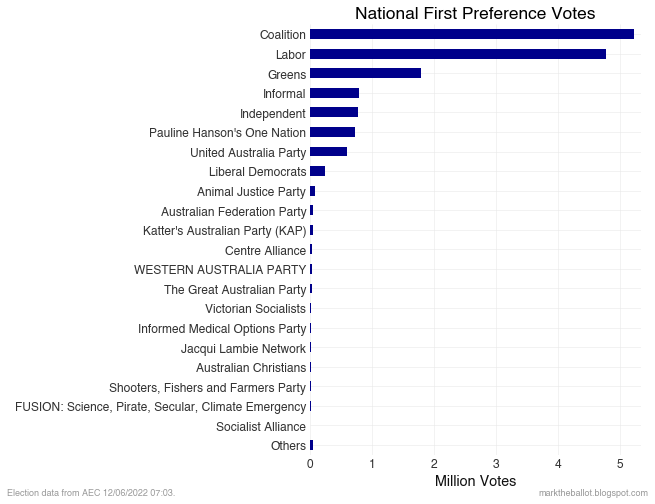

In [38]:
fig, ax = common.initiate_plot()
ax.figure.set_size_inches(9, 7)
fp_by_name[::-1].div(1_000_000).plot.barh(ax=ax, color='darkblue')
common.plot_finalise(
    ax, 
    title='National First Preference Votes',
    ylabel=None,
    xlabel='Million Votes', 
    lfooter=LFOOTER, 
)


### State 2pp swings

In [39]:
def set_up_swing_chart(data:pd.Series):
    
    assert isinstance(data, pd.Series)
    fig, ax = common.initiate_plot()
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)

    rightax = ax.twinx()
    ax.get_shared_y_axes().join(ax, rightax)
    rightax.grid(False)
    
    sorted_data = data.sort_values()
    labels = sorted_data.index
    sorted_data = sorted_data.reset_index(drop=True)
    
    ylims = sorted_data.index.min() - 0.5, sorted_data.index.max() + 0.5
    ax.set_ylim(ylims)
    rightax.set_ylim(ylims)
   
    return ax, rightax, sorted_data, labels


def finalise_swing_chart(ax, rightax, data, labels):

    ax.yaxis.set_ticks_position('left')
    rightax.yaxis.set_ticks_position('right')
    ax.spines['left'].set_position(('data',0),)
    ax.spines['left'].set_color('#999999')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    rightax.spines['right'].set_position(('data',0))

    ax.set_yticks(data.index)
    rightax.set_yticks(data.index)

    ax.set_yticklabels(labels.where(data >= 0, other=''))
    rightax.set_yticklabels(labels.where(data < 0, other=''))


In [40]:
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1779425,48.47,1891849,51.53,3671274,-3.31,5472469,67.086246
VIC,VIC,Victoria,1335497,45.01,1631436,54.99,2966933,-1.85,4344208,68.296292
QLD,QLD,Queensland,1405048,55.10,1145093,44.90,2550141,-3.34,3503609,72.786119
WA,WA,Western Australia,605412,44.22,763613,55.78,1369025,-11.33,1773969,77.172995
SA,SA,South Australia,449192,45.76,532381,54.24,981573,-3.53,1272047,77.164837
TAS,TAS,Tasmania,138571,48.82,145270,51.18,283841,4.78,402331,70.549125
ACT,ACT,Australian Capital Territory,67631,35.67,121979,64.33,189610,-2.72,314329,60.322147
NT,NT,Northern Territory,44872,44.46,56065,55.54,100937,-1.34,145938,69.164303


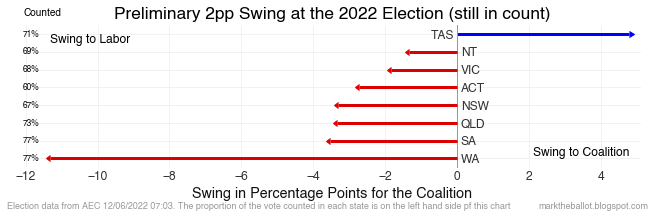

In [41]:
# marshall our data
data = houseTppByState['Swing']

# plot our data
ax, rightax, data, labels = set_up_swing_chart(houseTppByState['Swing'])
ax.figure.set_size_inches(9, 3)
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each state
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByState.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

# annotate axes
ax.text(data.min(), data.index.max(), 'Swing to Labor',
        ha='left', va='top', fontsize='large')
ax.text(data.max(), data.index.min(), 'Swing to Coalition',
        ha='right', va='bottom', fontsize='large')

common.plot_finalise(
    ax, 
    title='Preliminary 2pp Swing at the 2022 Election (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points for the Coalition', 
    lfooter=LFOOTER +
            'The proportion of the vote counted in each state is on the left hand side pf this chart', 
)

### State primary first preference swings

In [42]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}

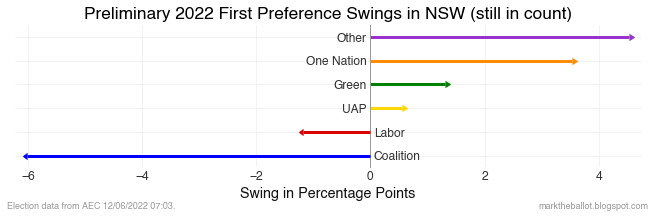

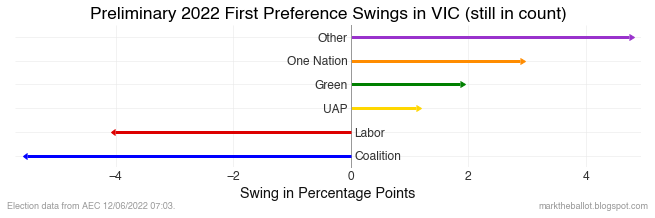

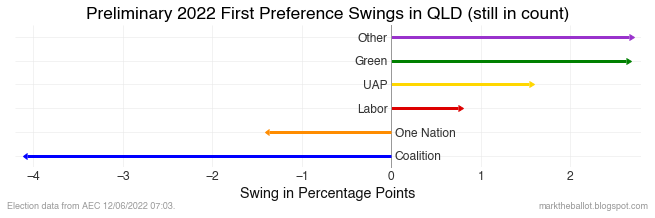

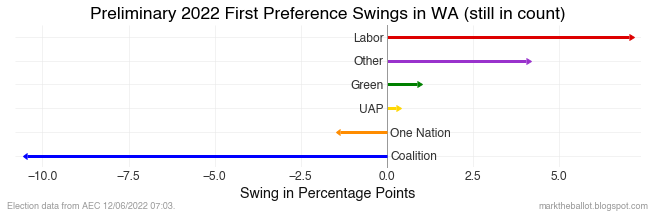

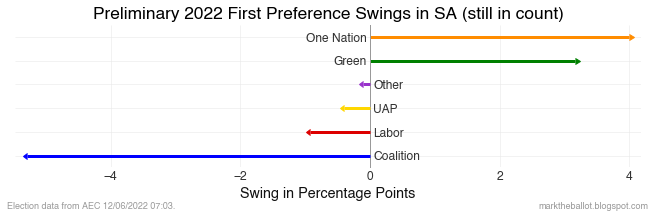

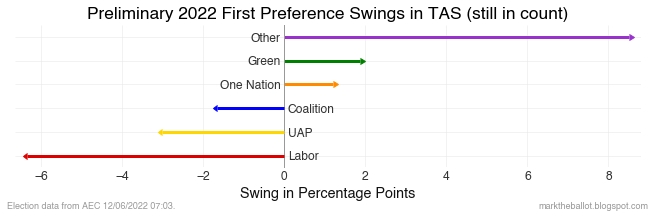

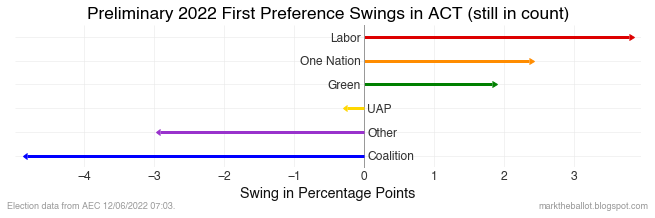

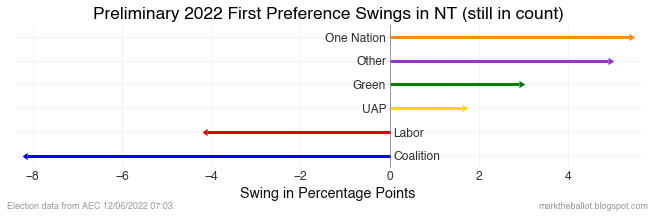

In [43]:
d22 = houseFirstPrefsByStateByParty2022
d19 = houseFirstPrefsByStateByParty2019

combined = {}
for state in d22['StateAb'].unique():

    # data marshalling 
    state2022 = d22[d22['StateAb'] == state].copy()
    state2019 = d19[d19['StateAb'] == state].copy()
    grouped2022 = get_group_totals(state2022)
    grouped2019 = get_group_totals(state2019)
    swings2022 = (grouped2022 - grouped2019).sort_values()
    for group, value in swings2022.iteritems():
        if group in combined:
            combined[group] = combined[group] | {state: value} # Python 3.10 feature
        else:
            combined[group] = {state: value}
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(swings2022)
    ax.figure.set_size_inches(9, 3)


    for x, y, l in zip(data, data.index, labels):
        ecolor = colours[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)

    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings in {state} (still in count)',
        ylabel=None,
        xlabel='Swing in Percentage Points', 
        lfooter=LFOOTER, 
    )    

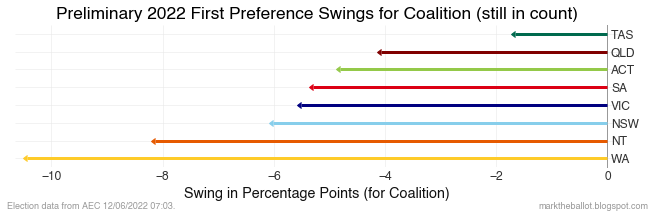

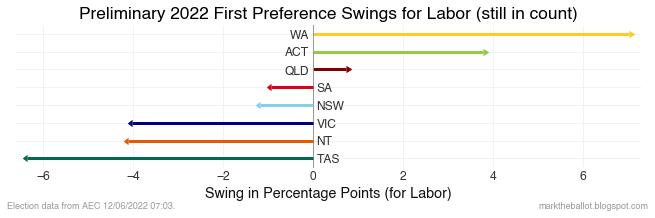

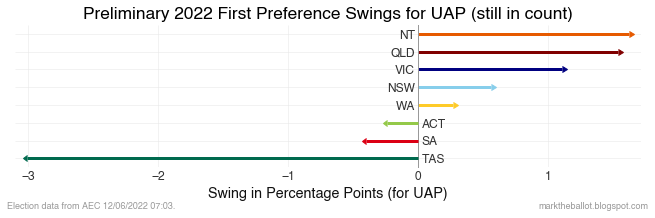

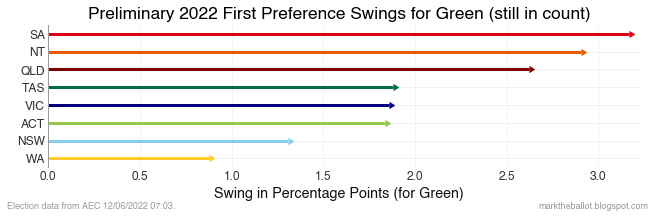

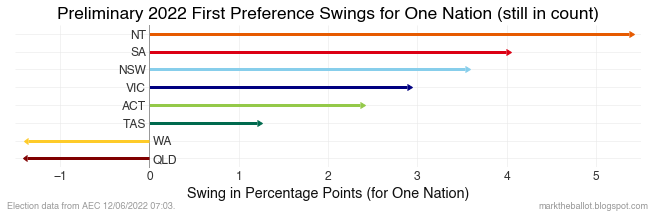

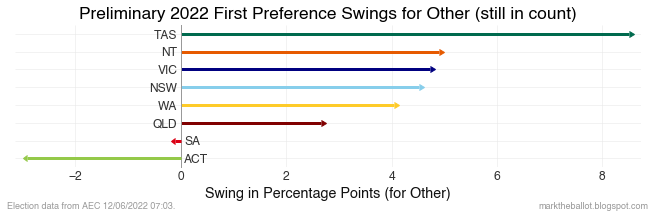

In [44]:
state_palette = {
    # colours from the R strayr package
    "NSW": '#87ceeb',
    "VIC": '#000080', 
    "QLD": '#800000', 
    "WA": '#fecb29', 
    "SA": '#dc0014', 
    "TAS": '#006a4e', 
    "ACT": '#94c949', 
    "NT": '#e65a00',
}

for group, dict_ in combined.items():
    
    # data
    series = pd.Series(dict_)
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(series)
    ax.figure.set_size_inches(9, 3)
    
    for x, y, l in zip(data, data.index, labels):
        ecolor = state_palette[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)
    
    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings for {group} (still in count)',
        ylabel=None,
        xlabel=f'Swing in Percentage Points (for {group})', 
        lfooter=LFOOTER, 
    )        


### Divisional 2pp swings

In [45]:
houseTppByDivision

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,43016,38.14,69766,61.86,112782,-3.68,130151,86.654732
Aston (VIC),Aston,197,VIC,NaN,51867,52.83,46301,47.17,98168,-7.30,109826,89.385027
Ballarat (VIC),Ballarat,198,VIC,NaN,35467,36.75,61045,63.25,96512,-3.02,110704,87.180228
Banks (NSW),Banks,103,NSW,NaN,48969,53.20,43076,46.80,92045,-3.06,107786,85.396063
Barker (SA),Barker,180,SA,NaN,70436,66.57,35371,33.43,105807,-2.37,123518,85.661199
...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa (NSW),Werriwa,153,NSW,NaN,44402,44.11,56253,55.89,100655,-0.42,126141,79.795626
Whitlam (NSW),Whitlam,150,NSW,NaN,43654,39.93,65683,60.07,109337,0.84,125535,87.096826
Wide Bay (QLD),Wide Bay,178,QLD,NaN,58572,61.19,37148,38.81,95720,-1.96,115420,82.931901
Wills (VIC),Wills,234,VIC,NaN,0,0.00,0,0.00,0,-24.29,108500,0.000000


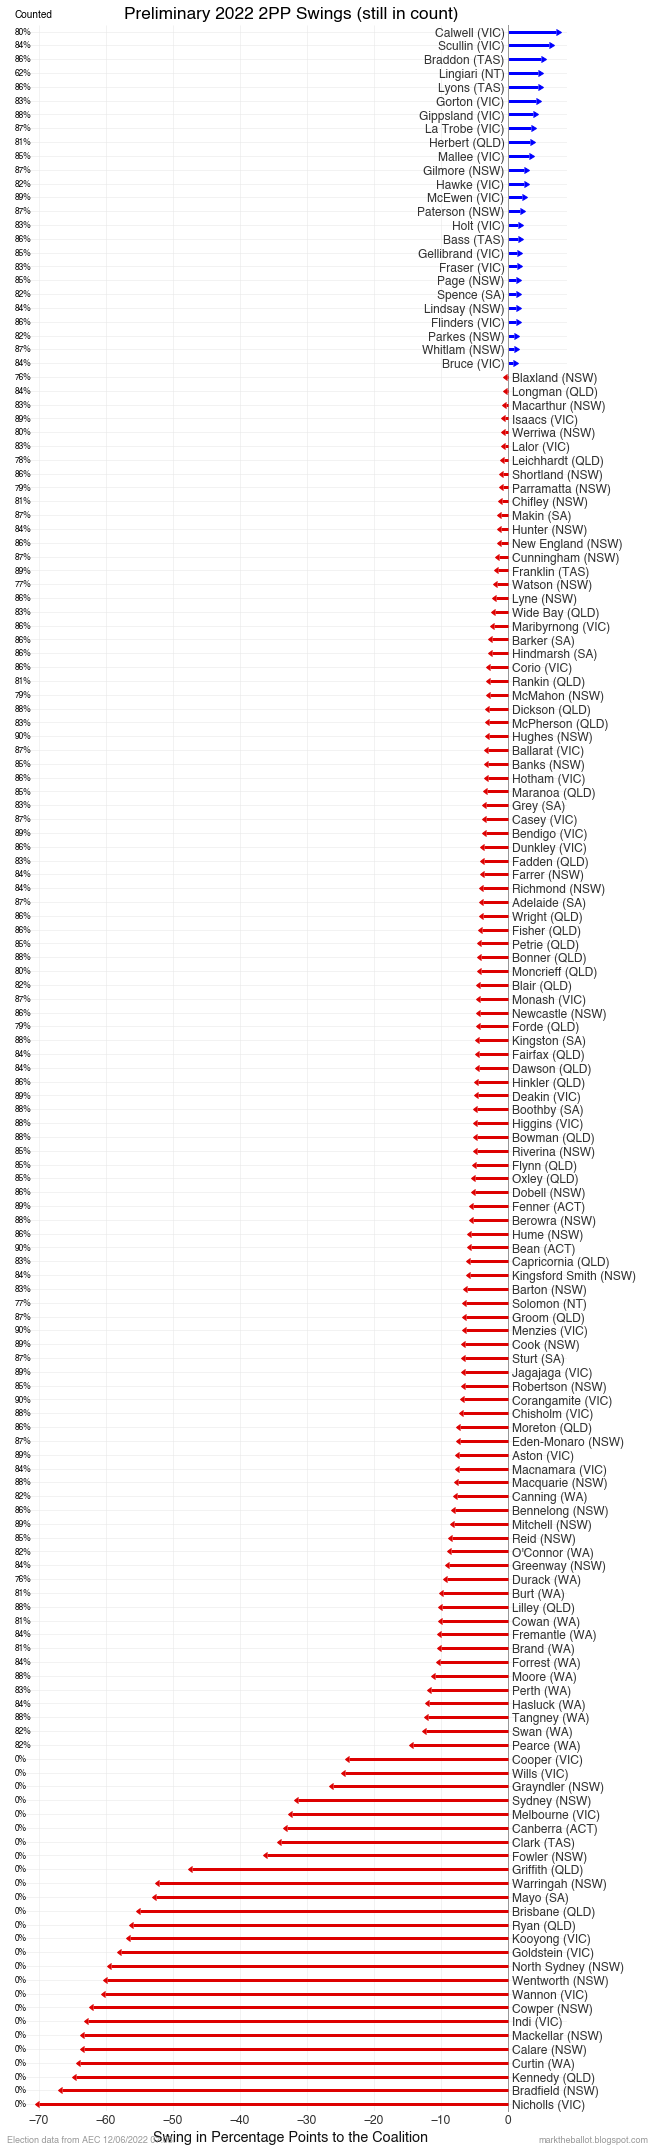

In [46]:
data = houseTppByDivision['Swing'].copy()
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9, 30)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')

finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByDivision.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Preliminary 2022 2PP Swings (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=LFOOTER, 
)    

### Green TCP swings

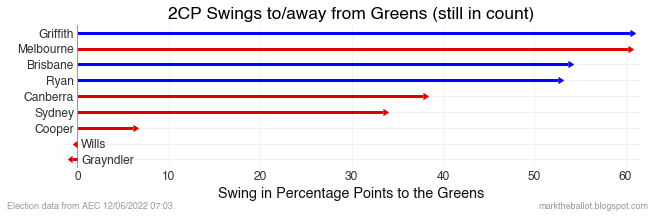

In [47]:
x_colors = {
    'ALP': '#dd0000',
    'Coalition': 'blue',
    'GRN': 'limegreen',
    'IND': 'darkorange'
}

GREEN = 'GRN'
orig_ = tcp_swings[tcp_swings[GREEN].notna()]
greens = orig_[GREEN]

ax, rightax, series, labels = set_up_swing_chart(greens)
ax.figure.set_size_inches(9, 3)

# plot our data
for x, y, label in zip(series, series.index, labels):
    kommen = orig_.drop(GREEN, axis=1).loc[label].idxmax()
    c = x_colors[kommen]
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=c)
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=c)
        
finalise_swing_chart(ax, rightax, series, labels)

common.plot_finalise(
    ax, 
    title=f'2CP Swings to/away from Greens (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Greens', 
    lfooter=LFOOTER, 
) 

### Traditional TCP swings

In [48]:
missing = tcp_swings.isna().all(axis=1)
missing_text = f'Missing from AEC feed: {(", ").join(missing[missing].index)}.' if missing.any() else ''
missing_text

''

In [49]:
TRADITIONAL = ['ALP', 'Coalition']
data = tcp_swings[tcp_swings[TRADITIONAL].notna().all(axis=1)]
data = data['Coalition']
data

DivisionNm
Adelaide   -3.68
Aston      -7.30
Ballarat   -3.02
Banks      -3.06
Barker     -2.37
            ... 
Watson     -1.68
Werriwa    -0.42
Whitlam     0.84
Wide Bay   -1.96
Wright     -3.71
Name: Coalition, Length: 125, dtype: float64

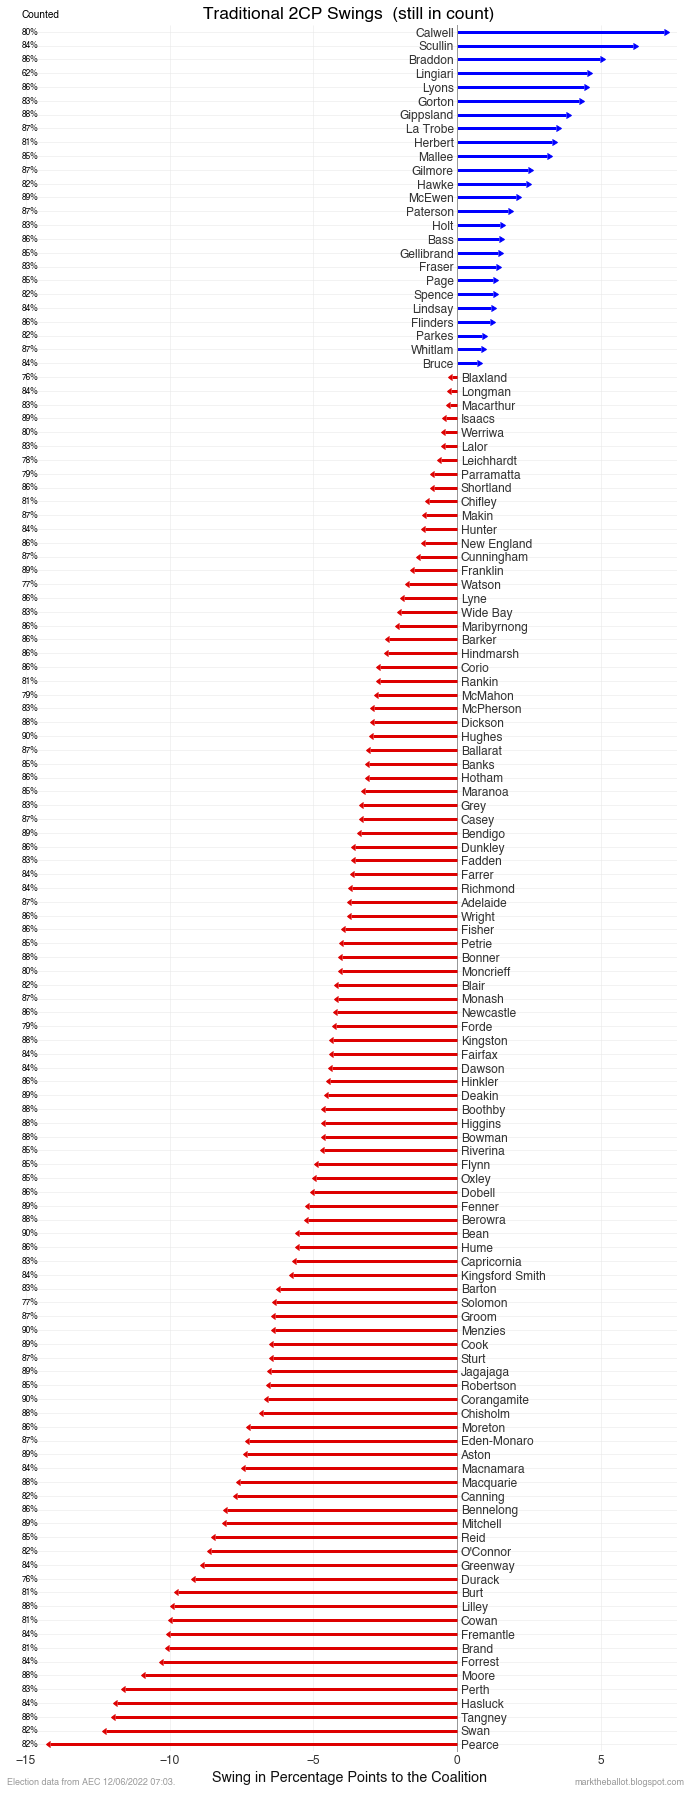

In [50]:
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9.5, 25)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{cooked_tcp_counted[label]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Traditional 2CP Swings  (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=f'{LFOOTER}{missing_text}', 
)    

In [51]:
tcp_swings.loc['Brisbane']

PartyAb
ALP            NaN
GRN          53.73
IND            NaN
KAP            NaN
XEN            NaN
Coalition    46.27
Name: Brisbane, dtype: float64

## Seat allocations

### Tally Class

In [52]:
class Tally:
    
    """Maintain sets of won seats for each party.
       Initially all seats are UNALLOCATED. As seats are 
       allocated they are removed from the UNALLOCATED set,
       and put into the set for the nominated party outcome."""
    
    UNALLOCATED = 'Unallocated'
    STAR = '*' # a useful catch-all - elections can have 50 micro parties
    
    
    def __init__(self, seat_list: List[str]):
        """Create a Tally with seats from seat_list Initialise  
           with all seats from the seat_list in the 
           'Unallocated' category."""
        self.tally = {}
        self.tally[self.UNALLOCATED] = set(seat_list)
        self.block_list = []

        
    # --- allocation related methods
        
    def set_manual_block(self, block_list: List[str]) -> None:
        """Provide a list of seats that cannot be moved."""
        self.block_list = block_list

        
    def move(self, bundle: List[str], source:str, dest:str) -> None:
        """Move seats in bundle list from the source outcome category 
           to the destination outcome category. Create a tally for
           destination if one does not already exist. """
        if dest not in self.tally.keys():
            self.tally[dest] = set()
        moving = set(bundle).intersection(self.tally[source])
        moving.difference_update(self.block_list)
        self.tally[source].difference_update(moving)
        self.tally[dest].update(moving)

        
    def allocate_seats(self, seats:pd.Series, assignmap:Dict[str,str]):
        """Allocate seats that have been declared by the AEC.
           seats is a series, with the seat as an index and the 
           winning party as the series. Assignmap allows multiple
           parties in coalition to be mapped to the same tally."""
        for party in seats.unique():
            print(party)
            bundle = seats[seats == party].index.to_list()
            self.move(bundle, self.UNALLOCATED, assignmap[party])


    def _get_default(self, a_map:Dict[str, str]) -> str:
        return a_map.get(self.STAR, '???')
            
    def allocate_by_threshold(self, 
               vote_df: pd.DataFrame, # in whole percentgaes
               count_s: pd.Series,    # in whole percentages
               assignmap: Dict[str, str], 
               thresholds: Dict[float, float]):
        """Alocate seats to a party based on the highest vote for a seat,
           and how much of the vote has been counted in each seat. 
           Use the assignmap to allocate a party to a party-grouping in the tally."""
        default = self._get_default(assignmap) 
        for vote_t, count_t in thresholds.items():
            frame = vote_df.loc[(vote_df.max(axis=1) > vote_t)
                                & (count_s > count_t)]
            if not len(frame): 
                continue
            movers = frame.idxmax(axis=1)
            for party in movers.unique():
                bundle = movers[movers == party].index.to_list()
                self.move(bundle, self.UNALLOCATED, assignmap.get(party, default))

                
    
    # --- information methods 
            
    def check_allocations(self, tcp_percent: pd.DataFrame, a_map: Dict[str, str]):
        """Return a list of seat allocations that are inconsistent with the
           latest TCP count."""
        tally_dict = {}
        for outcome, seats in self.tally.items():
            for seat in seats:
                tally_dict[seat] = outcome
        tally_series = pd.Series(tally_dict).sort_index()
        tcp_result = tcp_percent.idxmax(axis=1).sort_index()
        default = self._get_default(a_map) 
        tcp_result = tcp_result.apply(lambda x: a_map.get(x, default))
        problematic = tally_series != tcp_result
        return problematic[problematic].index.to_list()

                
    def get_seat_list(self, outcome_cat: str)-> List[str]:
        """Return a python list of all seats in a tally category."""
        return sorted(self.tally[outcome_cat])
    
    
    def get_seat_stringlist(self, outcome_cat: str)-> str:
        """Return a comma separated list of seats in the 
           desired outcome strategy."""
        return ', '.join(self.get_seat_list(outcome_cat))
    
    
    def get_seat_count(self, outcome_cat: str)-> str:
        """Return the seat count for a specific outcome category."""
        return len(self.tally[outcome_cat])

    
    def get_seat_counts(self) -> pd.Series:
        """Return a Series of seat counts by tally category."""
        s = {}
        for outcome, seats in self.tally.items():
            s[outcome] = len(seats)
        return pd.Series(s)

            
    def print_all_results(self) -> None:
        """Print all tallies in long form."""
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)} - '
                  f'({self.get_seat_stringlist(outcome)})')

            
    def print_all_counts(self) -> None:
        """Print all tally counts."""
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)}')


### Get status of individual seats

In [53]:
def print_seat_status(k):
    print(k)
    print('% Primary Counted:', fp_count_pct[k])
    print('First preferences:\n', fp_fomal_vote_pct_party.loc[k].dropna())
    print('% TCP Counted:', cooked_tcp_counted[k])
    print('TCP:\n', raw_pct_tcp_votes.loc[k].dropna())
    print('=' * 20)    

### Thresholds for counting purposes

In [54]:
TCP_THRESH = {
    # Threshholds for moving a seat from unallocated ...
    # vote_threshold, count_threshold (%)
    50.2:             89.5,
    50.3:             84.5,
    50.4:             79.5,
    50.5:             75.0,
    50.75:            70.0,
    51.0:             65.0,
    51.5:             60.0,
    52.0:             50.0,
    55.0:             45.0,
    60.0:             40.0,
}

FP_THRESH = {
    # Vote, Count
    50.0: 50,
    45.0: 60, # think hard about this one 
}

seat_list = fp_formal_by_div_by_party.index.to_list()

assign_map = {
    # Thresholds for assigning seat based on a column in 
    # a DataFrame (seats x party) and a set threshold
    
    # DataFrame Party, Outcome Category
    'Coalition': 'Coalition',
    'LP': 'Coalition',
    'LNP': 'Coalition',
    'CLP': 'Coalition',
    'NP': 'Coalition',
    'Labor': 'Labor',
    'ALP': 'Labor',
    'GRN': 'Green',
    'IND': 'Independent', 
    '*': 'Other',  # Use star for mopping up others ...
}

### Initialise tally - apply any manual blocks

In [55]:
tally = Tally(seat_list)

In [56]:
if False:
    MANUAL_BLOCK = ['Macnamara'] # reasonable argument that Greens come in above LAbor
    tally.set_manual_block(MANUAL_BLOCK)

### Do the declared seats

In [57]:
tally.allocate_seats(elected, assign_map)
tally.print_all_counts()

ALP
LP
IND
NP
LNP
Unallocated: 90
Labor: 36
Coalition: 19
Independent: 6


### Ugly manual adjustments

In [58]:
# Brisbane and Macnamara were resolved through a 3-candidate-preferred count
# Note: not yet carried over to the 2CP count
# https://www.aec.gov.au/news/results-3cp.htm#:~:text=The%20AEC%20will%20conduct%20three,be%20determined%20with%20sufficient%20certainty.

# Linguiari has a low turnout - but most likely will stay Labor. 

ugly_seats = pd.Series({
    'Lingiari': 'ALP', 
})
tally.allocate_seats(ugly_seats, assign_map)
tally.print_all_counts()

ALP
Unallocated: 90
Labor: 36
Coalition: 19
Independent: 6


In [59]:
# Let's just print details on every seat we are moving manually
for seat in ugly_seats.keys():
    print_seat_status(seat)

Lingiari
% Primary Counted: 66.79135719108712
First preferences:
 PartyAb
ALP     36.556
CEC      1.085
CLP     34.692
GRN     10.953
IND      2.962
LDP      4.252
ON       5.392
UAPP     4.108
Name: Lingiari, dtype: float64
% TCP Counted: 61.866306549628625
TCP:
 PartyAb
ALP    50.945167
CLP    49.054833
Name: Lingiari, dtype: float64


### First Preferences

In [60]:
tally.allocate_by_threshold(fp_fomal_vote_pct_party, fp_count_pct, assign_map, 
                          FP_THRESH)
tally.get_seat_counts()

Unallocated    68
Labor          45
Coalition      30
Independent     7
Green           1
dtype: int64

### TCP counts

In [61]:
tally.allocate_by_threshold(cooked_pct_tcp_votes, cooked_tcp_counted, 
                          assign_map, TCP_THRESH)

house = tally.get_seat_counts().sort_values()
house

Unallocated     1
Other           2
Green           4
Independent    10
Coalition      58
Labor          76
dtype: int64

### State of play

In [62]:
tally.print_all_results() 

Unallocated: 1 - (Gilmore)
Labor: 76 - (Adelaide, Ballarat, Barton, Bean, Bendigo, Bennelong, Blair, Blaxland, Boothby, Brand, Bruce, Burt, Calwell, Canberra, Chifley, Chisholm, Cooper, Corangamite, Corio, Cowan, Cunningham, Dobell, Dunkley, Eden-Monaro, Fenner, Franklin, Fraser, Fremantle, Gellibrand, Gorton, Grayndler, Greenway, Hasluck, Hawke, Higgins, Hindmarsh, Holt, Hotham, Hunter, Isaacs, Jagajaga, Kingsford Smith, Kingston, Lalor, Lilley, Lingiari, Lyons, Macarthur, Macnamara, Macquarie, Makin, Maribyrnong, McEwen, McMahon, Moreton, Newcastle, Oxley, Parramatta, Paterson, Pearce, Perth, Rankin, Reid, Richmond, Robertson, Scullin, Shortland, Solomon, Spence, Swan, Sydney, Tangney, Watson, Werriwa, Whitlam, Wills)
Coalition: 58 - (Aston, Banks, Barker, Bass, Berowra, Bonner, Bowman, Braddon, Bradfield, Calare, Canning, Capricornia, Casey, Cook, Cowper, Dawson, Deakin, Dickson, Durack, Fadden, Fairfax, Farrer, Fisher, Flinders, Flynn, Forde, Forrest, Gippsland, Grey, Groom, Herber

### State of the House

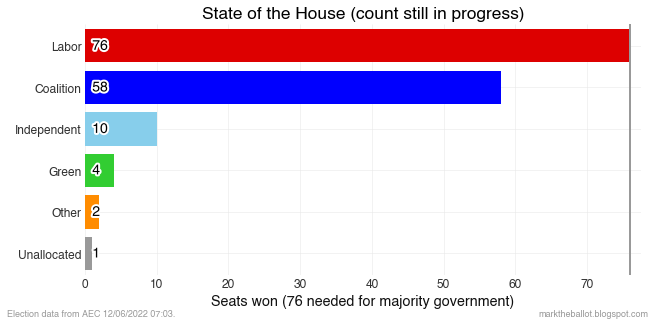

In [63]:
def plot_state_of_house(tally, title):
    
    cmap = {
        'Labor': '#dd0000',
        'Coalition': 'blue',
        'Independent': 'skyblue',
        'Unallocated': '#999999',
        'Green': 'limegreen',
        'Other': 'darkorange',
    }
    
    house = tally.get_seat_counts().sort_values()

    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    ax.axvline(76, c='#999999')
    for party, count in house.iteritems():
        if count <= 0:
            continue
        ax.barh(party, count, color=cmap[party])
        text = ax.text(1, party, f'{count}', ha='left', va='center', fontsize=14)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Seats won (76 needed for majority government)',
        lfooter=LFOOTER, 
    )
    
plot_state_of_house(tally, 'State of the House (count still in progress)')

### House outcome and closer seats

In [64]:
def get_close(close):
    close_tcp_votes = cooked_pct_tcp_votes.loc[close]
    max_value = close_tcp_votes.max(axis=1)
    max_label = close_tcp_votes.idxmax(axis=1)
    min_label = close_tcp_votes.idxmin(axis=1)
    return (
        pd.DataFrame({'Values': max_value.values, 
                      'Group': max_label.values, 
                      'Seat': close_tcp_votes.index },
                      index=[f'{seat} {a}-vs-{b}' 
                             for seat, a, b in zip(close_tcp_votes.index, max_label, min_label)],)
    ).sort_values('Values')


In [65]:
def plot_close(data:pd.DataFrame, title):
    
    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for x, y, c in zip(data['Values'], data.index, data['Group']):
        if math.isnan(x):
            x=50
        color = x_colors[c] if c in x_colors else 'white'
        ax.barh(y, x-50, left=50, color=color)

    # add in the count completion percentages for each division
    xlim_lo, xlim_high = ax.get_xlim()
    adj = (xlim_high - xlim_lo) * 0.025
    ax.set_xlim(xlim_lo, xlim_high+adj)
    for y, label in enumerate(data['Seat']):
        if math.isnan(x):
            continue
        text = f'{cooked_tcp_counted[label]:0.0f}%'
        ax.text(xlim_high+adj, y, text, ha='right', va='center', fontsize='small')
    ax.text(xlim_high+adj, y+0.5, 'Counted', ha='right', va='center', )

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Per cent two-candidate-preferred vote share', 
        lfooter=LFOOTER, 
    )

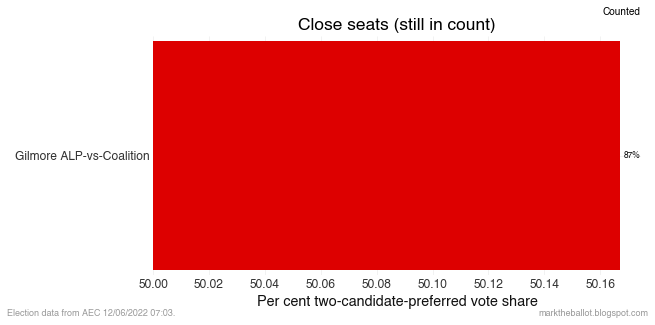

In [66]:
close = get_close(tally.get_seat_list(tally.UNALLOCATED))
if len(close):
    plot_close(close, 'Close seats (still in count)')

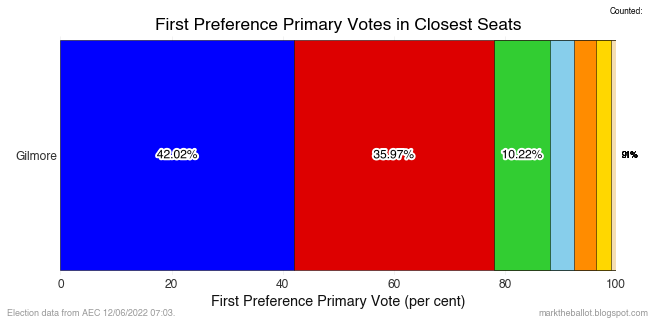

In [67]:
# Primaries for close counts
def plot_primaries(seats):
    seats = sorted(seats)
    
    colors = {
        'LP': 'blue',
        'LNP': 'blue',
        'CLP': 'blue',
        'NAT': 'darkgreen',
        'ALP': '#dd0000',
        'GRN': 'limegreen',
        'ON': 'darkorange',
        'IND': 'skyblue',
        'UAPP': 'gold',
        'JLN': 'hotpink',
        'Other': 'wheat',
    }
    fig, ax = fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for seat in seats:
        primary = fp_fomal_vote_pct_party.loc[seat].dropna().sort_values(ascending=False)
        tally = 0.0
        for party, vote in primary.iteritems():
            color = colors['Other'] if party not in colors else colors[party]
            if tally == 0.0:
                ax.barh(seat, vote, color=color, edgecolor='black', linewidth=0.5)
            else:
                ax.barh(seat, tally+vote, left=tally, color=color, edgecolor='black', linewidth=0.5)
            if vote > 8:
                text = ax.text(tally+(vote/2), seat, f'{vote:0.2f}%', ha='center', va='center',
                    fontsize=12)
                text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])
            tally += vote
            count = f'{fp_count_pct[seat]:0.0f}%'
            ax.text(101, seat, count, ha='left', va='center', fontsize='small', fontweight='normal')
    ax.set_xlim((0, 100))
    ax.text(105, len(seats)-0.5, 'Counted:', ha='right', va='center', fontsize='small', )

    elements = []
    for party, color in colors.items():
        elements.append(Patch(facecolor=color, edgecolor='black', linewidth=0.5, label=party))
    #ax.legend(handles=elements, loc='best', ncol=len(elements),
    #          bbox_to_anchor=(0.96, 0), )
    
    common.plot_finalise(
        ax, 
        title='First Preference Primary Votes in Closest Seats',
        ylabel=None,
        xlabel='First Preference Primary Vote (per cent)', 
        lfooter=LFOOTER, 
    )
    
plot_primaries(tally.get_seat_list(tally.UNALLOCATED))

In [68]:
# Let's look in detail at the problematics ...
for k in tally.get_seat_list(tally.UNALLOCATED):
    print_seat_status(k)

Gilmore
% Primary Counted: 91.45935878675003
First preferences:
 PartyAb
ALP     35.965
GRN     10.221
IND      4.226
LDP      0.797
LP      42.022
ON       3.986
UAPP     2.782
Name: Gilmore, dtype: float64
% TCP Counted: 87.41362715100674
TCP:
 PartyAb
ALP    50.166958
LP     49.833042
Name: Gilmore, dtype: float64


### Hypothetically allocate remainders by hand

In [69]:
hypothetical = deepcopy(tally)
hypothetical.set_manual_block([])

In [70]:
# And we can move by hand if we really need to ...
if False:
    by_hand = {
        'Green': ['Macnamara', ],
    }

    for dest, bundle in by_hand.items():
        hypothetical.move(bundle, tally.UNALLOCATED, dest)

In [71]:
# Allocate using the very latest TCP count
tcp_hypo_thresh = {
    # vote, thresh
    50.0: 0.1, 
}

hypothetical.allocate_by_threshold(cooked_pct_tcp_votes, 
                                   cooked_tcp_counted, 
                                   assign_map, 
                                   tcp_hypo_thresh)

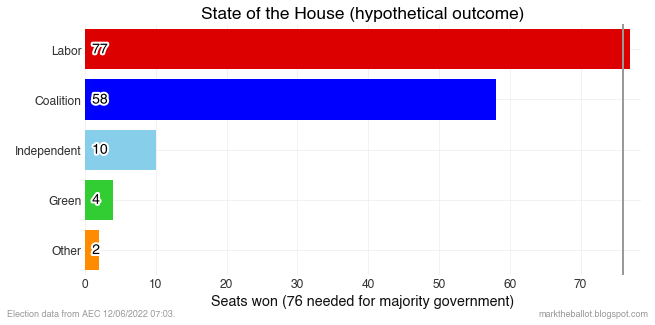

In [72]:
plot_state_of_house(hypothetical, 'State of the House (hypothetical outcome)')

In [73]:
# Check the hupothetical is consistent with the latest TCP counts ...
# If everything matches, there should be nothing to see here ...
l = hypothetical.check_allocations(cooked_pct_tcp_votes, assign_map)
if len(l):
    print(f'CAUTION: the hypothetical is inconsistent with the tally: {l}')
    
# CHECK CAREFULLY if anything printed below this cell

## The End

In [74]:
print('Done')

Done
